# Tutorial 4: Initializing a small-scale chain

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [71]:
# load compiled bed elevation measurements
df = pd.read_csv('DenmanDataGridded.csv')

In [72]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [73]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmachine_bed = df['bedmap_surf'].values.reshape(xx.shape) - bedmachine_thickness
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [74]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmap topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()
# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

__step1: calculate the trend__

In [95]:
initial_bed = np.loadtxt('Denman_bed_599000.txt')

In [96]:
import scipy as sp
trend = sp.ndimage.gaussian_filter(initial_bed, sigma=10)

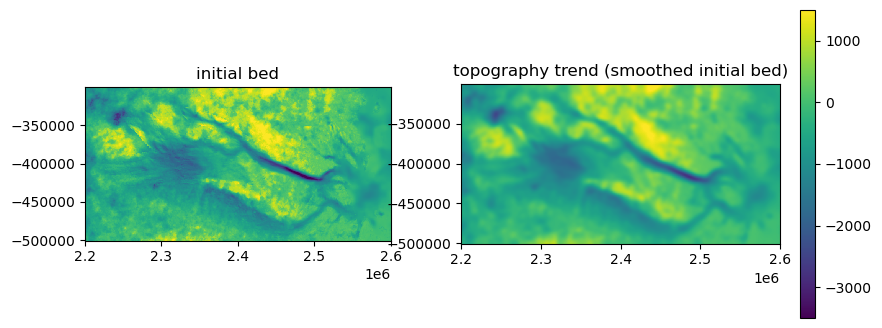

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),gridspec_kw={'width_ratios': [1, 1.3]} )

axes[0].pcolormesh(xx, yy, initial_bed, vmax=1500,vmin=-3500)
axes[0].set_title('initial bed')
axes[0].set_aspect('equal')

bedfig = axes[1].pcolormesh(xx, yy, smooth_trend, vmax=1500,vmin=-3500)
axes[1].set_title('topography trend (smoothed initial bed)')
axes[1].set_aspect('equal')
fig.colorbar(bedfig, ax=axes[1])

__step2: calculate detrended variogram__

In [98]:
###################WHEN NO DETREND###################
# normalize the conditioning bed data, saved to df['Nbed']
# data = df['cond_bed'].values.reshape(-1,1)
# nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
# transformed_data = nst_trans.transform(data)
# df['Nbed'] = transformed_data

In [99]:
# normalize the de-trended conditioning data, saved to df['Nbed_residual']
df['cond_bed_residual']=df['cond_bed'].values-trend.flatten()
data = df['cond_bed_residual'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed_residual'] = transformed_data

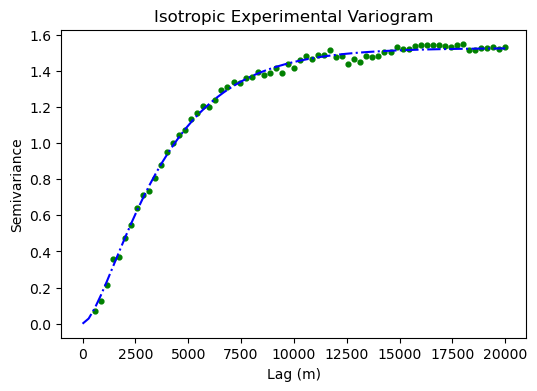

In [100]:
###################WHEN NO DETREND###################
# df_sampled = df.sample(frac=0.4, random_state=42)
# df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
# df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]
# coords = df_sampled[['x','y']].values
# values = df_sampled['Nbed']

# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed_residual"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed_residual']

maxlag = 20000      # maximum range distance
n_lags = 70         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False, model='matern')

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [101]:
V1_p

[10032.181352781196, 1.525739632455315, 0.9949631635071541, 0]

In [102]:
###################WHEN NO DETREND###################
# load the initial bed, make sure no bed in grounded ice region is higher altitude than ice surface
#sgs_bed = np.loadtxt('sgs_bed_totten_cropped.txt')
#thickness = bedmap_surf - sgs_bed
#sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

### Then initiating the SGS chain

The first 4 initialization process are very similar to chain_crf, please refers to Tutorial 3 for detailed information

In [103]:
grounded_ice_mask = (bedmap_mask == 1)

step3: set up the chain
- change initial bed
- set normal transformation
- set trend

In [104]:
###################WHEN NO DETREND###################
#smallScaleChain = MCMC.chain_sgs(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

In [105]:
smallScaleChain = MCMC.chain_sgs(xx, yy, initial_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_in_region(region_mask) and set_update_region(update_in_region)
please also set up the sgs parameters using set_sgs_param(self, block_size, sgs_param)
then please set up the loss function using either set_loss_type or set_loss_func


In [106]:
smallScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


In [107]:
smallScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)

In [108]:
# set up the block sizes
min_block_x = 5
max_block_x = 20
min_block_y = 5
max_block_y = 20
smallScaleChain.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Sequential Gaussian Simulation is set to perform on the normalized data. This nst_trans is an object of the QuantileTranformer class in scikit-learn python library. The *fit_variogram* function returns a nst_trans object, which could be directly used here

In [109]:
###################WHEN NO DETREND###################
#smallScaleChain.set_normal_transformation(nst_trans, do_transform=False)

In [110]:
smallScaleChain.set_normal_transformation(nst_trans, do_transform=True)

When running the SGS chain, it is possible to 'detrend' the topography.

Detrend topography refers to substracting a pre-defined trend from the topography map, where the trend suppose to represent long-wavelength features that violate stationary properties of SGS. If choose to detrend the topography, the argument *detrend_map* need to be set to True, and the argument *trend* need to be a 2D numpy array representing the topography trend

In [111]:
###################WHEN NO DETREND###################
#smallScaleChain.set_trend(trend = [], detrend_map = False)

In [112]:
smallScaleChain.set_trend(trend = trend, detrend_map = True)

In [113]:
smallScaleChain.set_variogram('Matern',V1_p[0],V1_p[1],0,isotropic=True,vario_smoothness=V1_p[2])

the variogram is set to type Matern


In [114]:
smallScaleChain.set_sgs_param(48, 50e3, sgs_rand_dropout_on=False)

because the sgs_rand_dropout_on is set to False, the dropout_rate is automatically set to 0


__step4: run the chain, check if the loss is correct__

In [115]:
seed = 23034902
randomGenerator = np.random.default_rng(seed)

beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = smallScaleChain.run(n_iter=100, rng_seed=randomGenerator, only_save_last_bed=False, info_per_iter = 1000)

i: 0 mc loss: 9.685e+05 loss: 9.685e+05 acceptance rate: 1.0


In [116]:
beds.shape

(100, 400, 800)

Text(0, 0.5, 'y (m)')

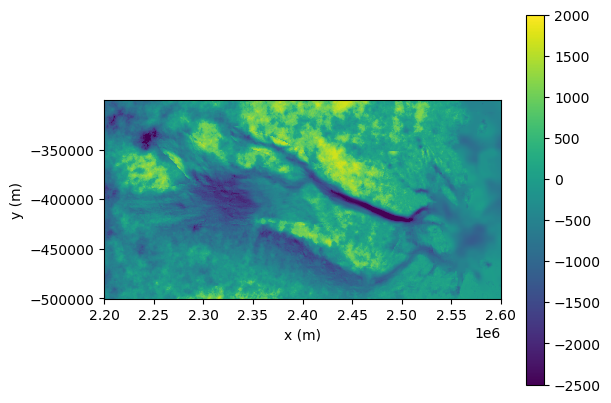

In [117]:
plt.pcolormesh(xx,yy,beds[0],vmax=2000,vmin=-2500)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0, 0.5, 'y (m)')

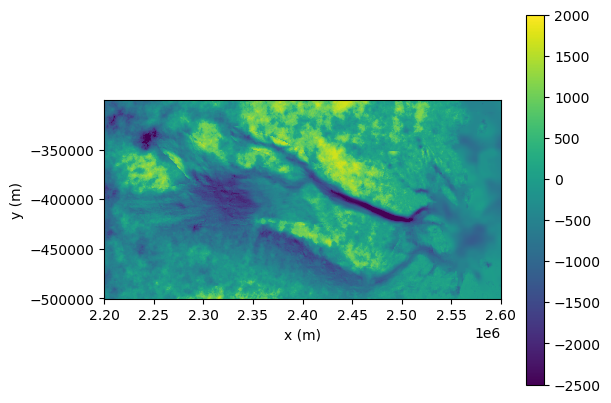

In [118]:
plt.pcolormesh(xx,yy,beds[-1],vmax=2000,vmin=-2500)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0, 0.5, 'y (m)')

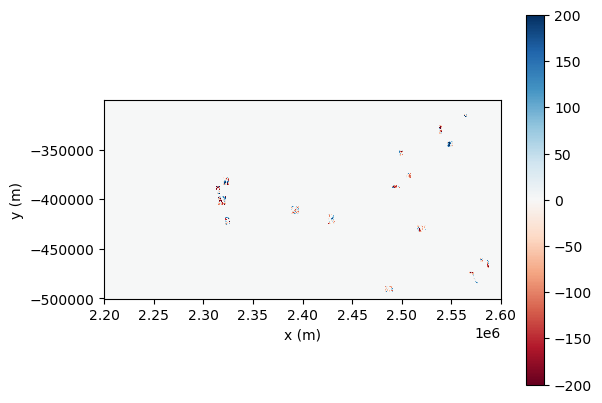

In [119]:
plt.pcolormesh(xx,yy,beds[-1]-beds[0], cmap='RdBu',vmax=200,vmin=-200)
plt.axis('scaled')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')